# Download GOES NetCDFs

In [ ]:
pip install s3fs

In [40]:
# Import libraries
import os
import s3fs
import numpy as np 
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

In [43]:
# create three folders in our main directory to store GOES netCDF files,
# “JPG” files of GOES files, and the timelapse file in the “Animation” folder.

# Create the folder names list
folder_names = ["GOES", "JPG", "Animation"]

# Iterate through the folder names and create the folders
for folder_name in folder_names:
    # Check if the folder doesn't exist, then create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Created folder: {folder_name}")
    else:
        print(f"Folder {folder_name} already exists")
              
GOES_dir = os.path.join(r"D:\GOES_content", "GOES")
JPG_dir = os.path.join(r"D:\GOES_content", "JPG")
Animation_dir = os.path.join(r"D:\GOES_content", "Animation")

Created folder: GOES
Created folder: JPG
Created folder: Animation


In [44]:
# specify the bucket name, product level, and the time for downloading the netCDF files

# Define the bucket and product
bucket = 'noaa-goes18' # other options: 'noaa-goes16', 'noaa-goes17', 'noaa-goe
product = 'ABI-L1b-RadC'

# Define the hour, day of the year and year
hour = 22
day = 31 
year = 2024

In [45]:
# connect to the file system
fs = s3fs.S3FileSystem(anon=True)

# Define the master URL
master_url = f'{bucket}/{product}/{year}/{day:03.0f}/{hour:02.0f}/'
print(master_url)

# Get the URLs for different channels
urls = fs.ls(master_url)

noaa-goes18/ABI-L1b-RadC/2024/031/22/


In [46]:
# Filter the list for these three channels (blue, red, and NIR)
urls_C01 = []
urls_C02 = []
urls_C03 = []

# We can select files with “C01” for blue, “C02” for red, and “C03” for the NIR band in their names
urls_C01 = [url for url in urls if url.endswith('.nc') and 'C01' in url]
urls_C02 = [url for url in urls if url.endswith('.nc') and 'C02' in url]
urls_C03 = [url for url in urls if url.endswith('.nc') and 'C03' in url]

# Sort the URLs
urls_C01.sort()
urls_C02.sort()
urls_C03.sort()

In [47]:
# Let's start downloading the first netCDF file in each list (eachchannel) and save them in our “GOES” folder
# Define the paths for different channels
path_C01 = os.path.join(GOES_dir, urls_C01[0].split("/")[-1])
path_C02 = os.path.join(GOES_dir, urls_C02[0].split("/")[-1])
path_C03 = os.path.join(GOES_dir, urls_C03[0].split("/")[-1])

# Download the data for different channels
print ("starting...")

fs.download(urls_C01[0], path_C01)
print(f"{urls_C01[0]} has been downloaded")

fs.download(urls_C02[0], path_C02)
print(f"{urls_C02[0]} has been downloaded")

fs.download(urls_C03[0], path_C03)
print(f"{urls_C03[0]} has been downloaded")

starting...
noaa-goes18/ABI-L1b-RadC/2024/031/22/OR_ABI-L1b-RadC-M6C01_G18_s20240312201185_e20240312203558_c20240312204004.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/22/OR_ABI-L1b-RadC-M6C02_G18_s20240312201185_e20240312203558_c20240312203591.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/22/OR_ABI-L1b-RadC-M6C03_G18_s20240312201185_e20240312203558_c20240312203595.nc has been downloaded


# Visualization of GOES Images

In [48]:
# Open the downloaded data using xarray
Blue = xr.open_dataset(path_C01)
Red = xr.open_dataset(path_C02)
Nir = xr.open_dataset(path_C03)

# Extract the data arrays
Blue_array = Blue.Rad.data
Red_array = Red.Rad.data
Nir_array = Nir.Rad.data

# Calculate the reflectance values
Blue_reflec = Blue.kappa0.data * Blue_array
Red_reflec = Red.kappa0.data * Red_array
Nir_reflec = Nir.kappa0.data * Nir_array

# Clip the reflectance values between 0 and 1
Blue_reflec_clip = np.clip(Blue_reflec, 0, 1)
Red_reflec_clip = np.clip(Red_reflec, 0, 1)
Nir_reflec_clip = np.clip(Nir_reflec, 0, 1)

# Apply gamma correction
gamma = 3
Blue_gamma = np.power(Blue_reflec_clip, 1/gamma)
Red_gamma = np.power(Red_reflec_clip, 1/gamma)
Nir_gamma = np.power(Nir_reflec_clip, 1/gamma)

In [61]:
# Define a function to downsample the array
def downsample_array(input_array):
    # Calculate the dimensions of the output array
    output_rows = input_array.shape[0] //2
    output_cols = input_array.shape[1] //2
    
    # Reshape the input array into a 4D array, then compute the mean along the
    reshaped_array = input_array.reshape(output_rows, 2, output_cols, 2)
    output_array = reshaped_array.mean(axis=(1,3))
    
    return output_array

# Downsample the Red_gamma array
Red_gamma_reshaped = downsample_array(Red_gamma)

# Calculate the Green channel using the Red, Blue and Nir channels
# // Bah, M. K., Gunshor, M. M., & Schmit, T. J. (2018). Generation of GOES-16
G_gamma = 0.45 * Red_gamma_reshaped + 0.1 * Nir_gamma + 0.45 * Blue_gamma

# Combine the Red, Green and Blue channels to create the RGB array for the true
RGB = np.dstack([Red_gamma_reshaped, G_gamma, Blue_gamma])

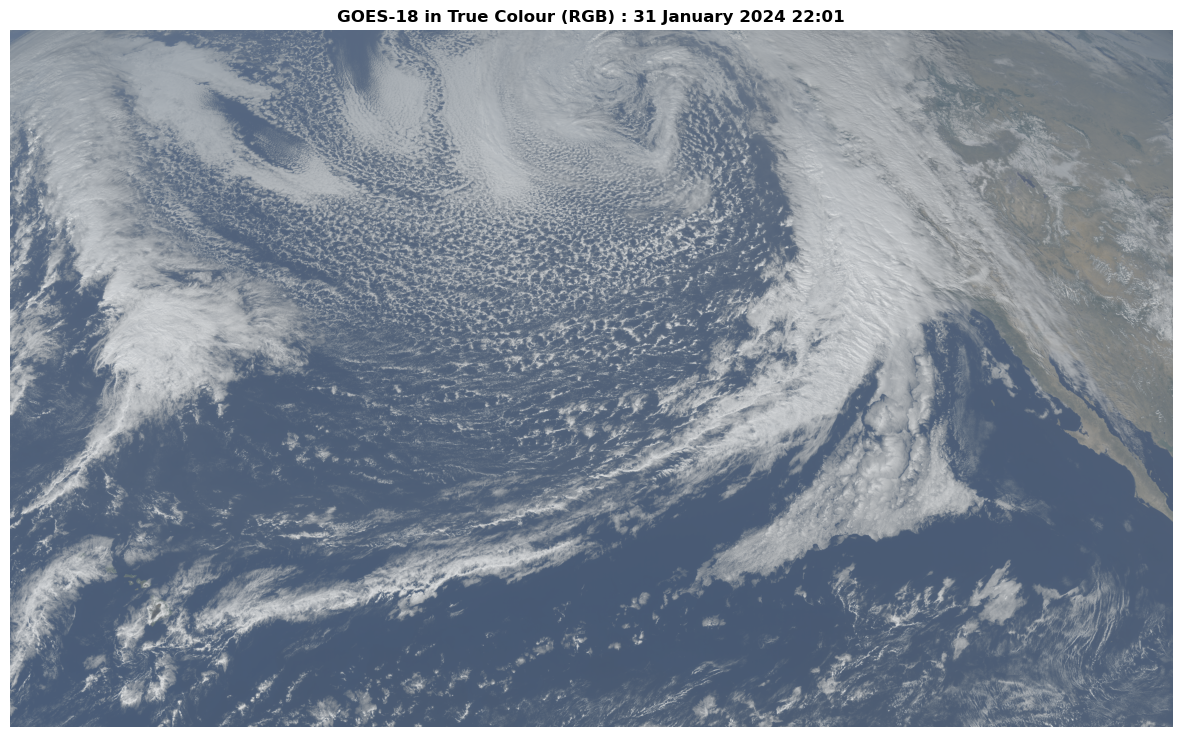

In [62]:
# Plot the true color image
fig = plt.figure(figsize=(15, 12))

plt.imshow(RGB)

# Get the scan start time and format it
#scan_start = datetime.strptime(Blue.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%f'Z
scan_start = datetime.strptime(Blue.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

Time = scan_start.strftime ('%d %B %Y %H:%M')

# Add title and axis labels to the plot
plt.title(f'GOES-18 in True Colour (RGB) : {Time}', fontweight='bold', fontsize=12)
plt.axis('off')

# Show the plot
plt.show()

# Timelapse of the Storm

In [63]:
# Define the bucket and product
bucket = 'noaa-goes18' # other options: 'noaa-goes16', 'noaa-goes17', 'noaa-goe
product = 'ABI-L1b-RadC'
# Define the hour, day of the year and year
hours = range(16,24)
day = 31 
year = 2024

In [64]:
# connect to the file system
fs = s3fs.S3FileSystem(anon=True)

# Filter the list for these three channels (blue, red, and NIR)
urls_C01 = []
urls_C02 = []
urls_C03 = []

for hour in hours:
    # Define the master URL
    master_url = f'{bucket}/{product}/{year}/{day:03.0f}/{hour:02.0f}/'
    print(master_url)
    
    # Get the URLs for different channels
    urls = fs.ls(master_url)
    urls_C01_hour = [url for url in urls if url.endswith('.nc') and 'C01' in url]
    urls_C02_hour = [url for url in urls if url.endswith('.nc') and 'C02' in url]
    urls_C03_hour = [url for url in urls if url.endswith('.nc') and 'C03' in url]
    
    urls_C01.extend(urls_C01_hour)
    urls_C02.extend(urls_C02_hour)
    urls_C03.extend(urls_C03_hour)
    
# Sort the URLs
urls_C01.sort()
urls_C02.sort()
urls_C03.sort()

noaa-goes18/ABI-L1b-RadC/2024/031/16/
noaa-goes18/ABI-L1b-RadC/2024/031/17/
noaa-goes18/ABI-L1b-RadC/2024/031/18/
noaa-goes18/ABI-L1b-RadC/2024/031/19/
noaa-goes18/ABI-L1b-RadC/2024/031/20/
noaa-goes18/ABI-L1b-RadC/2024/031/21/
noaa-goes18/ABI-L1b-RadC/2024/031/22/
noaa-goes18/ABI-L1b-RadC/2024/031/23/


In [72]:
# Image time 8:00 am to 3:00 pm = 7 hours
# download images captured every 15 minutes (4 images per hour)resulting in a total of (7 * 4 = 28 images)
for i in range (0, len(urls_C01), 4):
    path_C01 = os.path.join(GOES_dir, urls_C01[i].split("/")[-1])
    path_C02 = os.path.join(GOES_dir, urls_C02[i].split("/")[-1])
    path_C03 = os.path.join(GOES_dir, urls_C03[i].split("/")[-1])
    
    # Download the data for different channels
    print ("starting...")
    
    fs.download(urls_C01[i], path_C01)
    print(f"{urls_C01[i]} has been downloaded")
    
    fs.download(urls_C02[i], path_C02)
    print(f"{urls_C02[i]} has been downloaded")
    
    fs.download(urls_C03[i], path_C03)
    print(f"{urls_C03[i]} has been downloaded")


starting...
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20240311601184_e20240311603557_c20240311604000.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C02_G18_s20240311601184_e20240311603557_c20240311603594.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C03_G18_s20240311601184_e20240311603557_c20240311604005.nc has been downloaded
starting...
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20240311621184_e20240311623557_c20240311623595.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C02_G18_s20240311621184_e20240311623558_c20240311623586.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C03_G18_s20240311621184_e20240311623557_c20240311624002.nc has been downloaded
starting...
noaa-goes18/ABI-L1b-RadC/2024/031/16/OR_ABI-L1b-RadC-M6C01_G18_s20240311641184_e20240311643557_c20240311643594.nc has been downloaded
noaa-goes18/ABI-L1b-RadC/2

In [75]:
# If the JPG folder is not created in the path, go into the folder and create it manually.
# Define a function to downsample the array

def downsample_array(input_array):
    # Calculate the dimensions of the output array
    output_rows = input_array.shape[0] //2
    output_cols = input_array.shape[1] //2
    
    # Reshape the input array into a 4D array, then compute the mean along the
    reshaped_array = input_array.reshape(output_rows, 2, output_cols, 2)
    output_array = reshaped_array.mean(axis=(1,3))
    
    return output_array

def plot_GOES(path_C01, path_C02, path_C03, jpg_folder):
    # Open the downloaded data using xarray
    Blue = xr.open_dataset(path_C01)
    Red = xr.open_dataset(path_C02)
    Nir = xr.open_dataset(path_C03)
    
    # Extract the data arrays
    Blue_array = Blue.Rad.data
    Red_array = Red.Rad.data
    Nir_array = Nir.Rad.data
    
    # Calculate the reflectance values
    Blue_reflec = Blue.kappa0.data * Blue_array
    Red_reflec = Red.kappa0.data * Red_array
    Nir_reflec = Nir.kappa0.data * Nir_array
    
    # Clip the reflectance values between 0 and 1
    Blue_reflec_clip = np.clip(Blue_reflec, 0, 1)
    Red_reflec_clip = np.clip(Red_reflec, 0, 1)
    Nir_reflec_clip = np.clip(Nir_reflec, 0, 1)
    
    # Apply gamma correction
    gamma = 3
    Blue_gamma = np.power(Blue_reflec_clip, 1/gamma)
    Red_gamma = np.power(Red_reflec_clip, 1/gamma)
    Nir_gamma = np.power(Nir_reflec_clip, 1/gamma)
    
    # Downsample the Red_gamma array
    Red_gamma_reshaped = downsample_array(Red_gamma)
    
    # Calculate the Green channel using the Red, Blue and Nir channels
    # // Bah, M. K., Gunshor, M. M., & Schmit, T. J. (2018). Generation of GOES-16
    G_gamma = 0.45 * Red_gamma_reshaped + 0.1 * Nir_gamma + 0.45 * Blue_gamma
    
    # Combine the Red, Green and Blue channels to create the RGB array for the true
    RGB = np.dstack([Red_gamma_reshaped, G_gamma, Blue_gamma])
    
    # Plot the true color image
    fig = plt.figure(figsize=(15, 12))
    plt.imshow(RGB)
    
    # Get the scan start time and format it
    scan_start = datetime.strptime(Blue.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    Time = scan_start.strftime ('%d %B %Y %H:%M')
    
    #Add title and axis labels to the plot
    plt.title(f'GOES-18 in True Colour (RGB) : {Time}', fontweight='bold', fontsize=12)
    plt.axis('off')
    
    # Save the plot as a JPEG file with valid file name
    plt.savefig(os.path.join(f'D:/GOES_content/{jpg_folder}', 
                         scan_start.strftime('%Y-%m-%dT%H_%M_%S_%fZ') + '.jpg'))


    # Close the plot to free up memory
    plt.close(fig)
    


In [76]:
# call these two functions in a loop to plot and save all the images downloaded
# and processed from GOES in our JPG folder.

for i in range (0, len(urls_C01), 4):
    path_C01 = os.path.join(GOES_dir, urls_C01[i].split("/")[-1])
    path_C02 = os.path.join(GOES_dir, urls_C02[i].split("/")[-1])
    path_C03 = os.path.join(GOES_dir, urls_C03[i].split("/")[-1])

    # Call the function
    plot_GOES(path_C01, path_C02, path_C03, jpg_folder='JPG')

# Create an animation from the series of images 

In [78]:
# Install Pillow if you don't have it
# pip install pillow

from PIL import Image
import os
import glob

# Replace 'path/to/folder' with the path to your folder containing the jpg image

folder_path = 'D:/GOES_content/JPG'
output_gif = os.path.join('D:/GOES_content/Animation', 'GOES_animation.gif')

# Get a sorted list of all jpg files in the folder
file_list = sorted(glob.glob(os.path.join(folder_path, '*.jpg')))

# Set the desired dimensions for the images
width, height = 1500 , 1200

# Read the images and store them in a list
frames = []
for file in file_list:
    frame = Image.open(file)
    
    # Resize the image
    frame = frame.resize((width, height), Image.LANCZOS)
    
    # Add a white background to the image
    background = Image.new('RGB', frame.size, (255, 255,255))
    background.paste(frame)
    frame = background.convert('RGB')
    
    # Convert the image to P mode with a global color table
    frame = frame.convert('P', palette=Image.ADAPTIVE, colors=256)
    frames.append(frame)
    
# Save the frames as an animated GIF
if frames:
    frames[0].save(
        output_gif, 
        save_all=True, 
        append_images=frames[1:],
        duration=500, # Set the duration between frames in milliseconds 
        loop=0, # Set the number of loops (0 means infinite) 
        optimize=True,
    )
else:
    print("No jpg files found.")
    
# The output will be an animation, saved in your animation folder